# Training Bu2023Ye model

**Abstract** This is a notebook where I try to train a surrogate model for the Bu2023Ye model.

Note: The main difference from Bu2022Ye is that the new grid allows Yewind to take values of 0.2, 0.3, and 0.4, while the Bu2022Ye fixed the parameter at 0.3.

In [20]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py
import tqdm
import inspect 

# NMMA imports
import nmma
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
from nmma.em.training import SVDTrainingModel
import nmma.em.model_parameters as model_parameters

# tensorflow imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16
        }

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading and exploring the dataset

In [21]:
lcs_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/bulla_2023" # location on the Potsdam cluster
model_name = "Bu2023Ye"

filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

There are 33792 lightcurves for this model.


In [22]:
dat = pd.read_csv(full_filenames[0], delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
dat.head() # show first few rows

,t,sdssu,ps1::g,ps1::r,ps1::i,ps1::z,ps1::y,2massj,2massh,2massks,Unnamed: 10
0,0.103,-17.130,-16.909,-17.314,-16.282,-16.389,-15.942,-16.094,-10.886,-15.972,NaN
1,0.109,-19.091,-19.824,-19.942,-19.293,-19.654,-19.421,-19.040,NaN,-15.425,NaN
2,0.116,-19.754,-19.873,-19.537,-18.700,-18.927,-18.207,-19.835,-18.522,6.964,NaN
3,0.122,-18.931,-19.698,-19.497,-19.361,-18.508,-19.771,-18.812,-16.862,-15.640,NaN
4,0.130,-19.354,-19.786,-20.031,-18.963,-19.567,-19.251,-19.029,-18.540,-14.350,NaN


In [23]:
value_columns = dat.columns[1:-1] # discard first and last, to get "true" data columns
print(list(value_columns))

['sdssu', 'ps1::g', 'ps1::r', 'ps1::i', 'ps1::z', 'ps1::y', '2massj', '2massh', '2massks']


KeyboardInterrupt: 

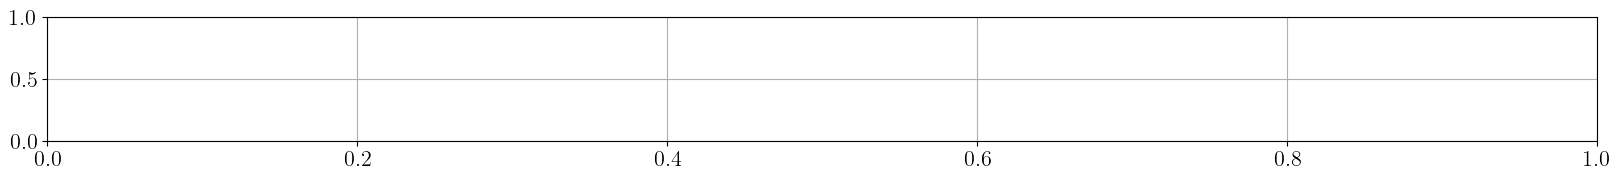

In [24]:
nrow = len(value_columns)
fig, axs = plt.subplots(nrow, 1, figsize=(20, 17), sharex = True)
t = dat["t"].values

for i, key in enumerate(value_columns):
    plt.subplot(nrow, 1, i+1)
    plt.plot(t, dat[key].values)
    plt.ylabel(key, rotation=0, labelpad=50)
    axs[i].invert_yaxis()
    # plt.grid()
plt.xlabel("Time [days]")
plt.show()

The following cell takes around 1 minute

In [ ]:
data = read_photometry_files(full_filenames)
data = interpolate_nans(data)
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))
print(filts)

['2massh', '2massj', '2massks', 'ps1__g', 'ps1__i', 'ps1__r', 'ps1__y', 'ps1__z', 'sdssu']


In [ ]:
MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
model_function = MODEL_FUNCTIONS[model_name]
training_data, parameters = model_function(data)

In [ ]:
print(parameters)

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'Yewind', 'KNtheta']


Check that the extraction of the parameters from the filenames makes sense - LGTM

In [ ]:
## There are two file name conventions here, so we have to check 
all_keys = list(training_data.keys())
first_file_names = [f for f in all_keys if f.startswith("MDyn")]
second_file_names = [f for f in all_keys if f.startswith("dyn")]

for example_key in [first_file_names[0], second_file_names[0]]:
    print("------------------")
    example_training_data = training_data[example_key]
    print(f"Keys (and some values) of dictionary of {example_key}")
    for key in example_training_data.keys():
        value = example_training_data[key]
        if key in parameters:
            print(f"{key} : {value}")

------------------
Keys (and some values) of dictionary of MDyn0.020_vDyn0.20_YeDyn0.30_MWind0.130_vWind0.05_YeWind0.2_theta53.13_dMpc0
log10_mej_dyn : -1.6989700043360187
vej_dyn : 0.2
Yedyn : 0.3
log10_mej_wind : -0.8860566476931633
vej_wind : 0.05
Yewind : 0.2
KNtheta : 53.13
------------------
Keys (and some values) of dictionary of dyn0.001-0.25-0.30_wind0.130-0.05_YeWind0.3_theta66.42_dMpc0
log10_mej_dyn : -3.0
vej_dyn : 0.25
Yedyn : 0.3
log10_mej_wind : -0.8860566476931633
vej_wind : 0.05
Yewind : 0.3
KNtheta : 66.42


## Getting SVD model

Note -- I made a quick edit in the NMMA source code to skip the model checking/loading as this will not work here.

In [ ]:
svd_ncoeff = 10
training_model = SVDTrainingModel(
        model_name,
        training_data,
        parameters,
        t,
        filts,
        n_coeff=svd_ncoeff,
        interpolation_type="tensorflow",
        svd_path = "/home/urash/twouters/new_nmma_models/Bu2023Ye_tf",
        start_training=False # don't train, just prep the data
        
    )

The grid will be interpolated to sample_time with interp1d


The following cell can take around 10 minutes...

In [ ]:
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model

Normalizing mag filter 2massh...
Normalizing mag filter 2massj...
Normalizing mag filter 2massks...
Normalizing mag filter ps1__g...
Normalizing mag filter ps1__i...
Normalizing mag filter ps1__r...
Normalizing mag filter ps1__y...
Normalizing mag filter ps1__z...
Normalizing mag filter sdssu...


## Training

### Investigating the PCA performance for the new model

Need to mimic the preprocessing steps done in the em/training file to check PCA performance

In [36]:
data_array_postprocess_dict = dict()

model_keys = list(training_model.data.keys()) # filenames of the LC data

# Loop through filters
for jj, filt in enumerate(training_model.filters):
    data_array = []
    for key in model_keys:
        data_array.append(training_model.data[key]["data"][:, jj])

    data_array_postprocess = np.array(data_array)
    mins, maxs = np.min(data_array_postprocess, axis=0), np.max(
        data_array_postprocess, axis=0
    )
    for i in range(len(mins)):
        data_array_postprocess[:, i] = (
            data_array_postprocess[:, i] - mins[i]
        ) / (maxs[i] - mins[i])
    data_array_postprocess[np.isnan(data_array_postprocess)] = 0.0
    
    # Save the results
    data_array_postprocess_dict[filt] = data_array_postprocess

In [39]:
# Check an example
example = data_array_postprocess_dict[filts[0]]
print(np.shape(example))
print(example)

(33792, 100)
[[0.14868224 0.07543838 0.01343563 ... 0.45079584 0.45387291 0.45625643]
 [0.13230324 0.05631885 0.0182265  ... 0.45530249 0.45848261 0.46094595]
 [0.12416059 0.06851641 0.03225141 ... 0.45572702 0.45841981 0.46050567]
 ...
 [0.14811476 0.07039554 0.0393169  ... 0.54306363 0.53337849 0.52587629]
 [0.13008536 0.08462322 0.04004761 ... 0.45531911 0.45837624 0.46074432]
 [0.15579404 0.08901904 0.01899256 ... 0.45151648 0.45450471 0.45681941]]


I will use sklearn's PCA (check documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) for its ease of use -- it should be equivalent to the one used in NMMA, or at least give the same indications regarding the performance of a PCA for this dataset.

I run two tests
1. I check the amount of explained variance for the different filters and check when we achieve a certain threshold such as 95%
2. I do the reconstruction for varying number of components to check if it makes sense.

The following takes around 1 minute to compute (the reconstruction error test is a bit slow).

**TODO** Check whether the method in NMMA, with np.linalg, indeed gives the same results.

In [47]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

For 2massh filter, 8 components explain 0.9533162277378788 of the variance.


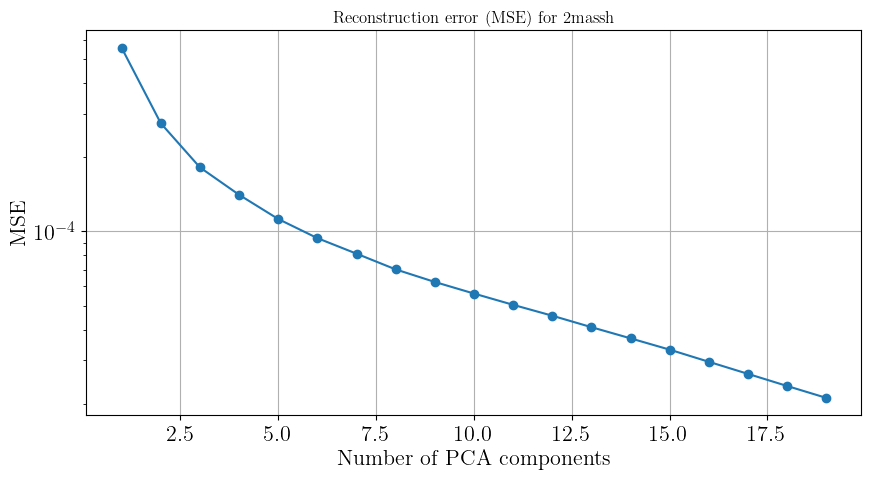

For 2massj filter, 6 components explain 0.9530458667951327 of the variance.


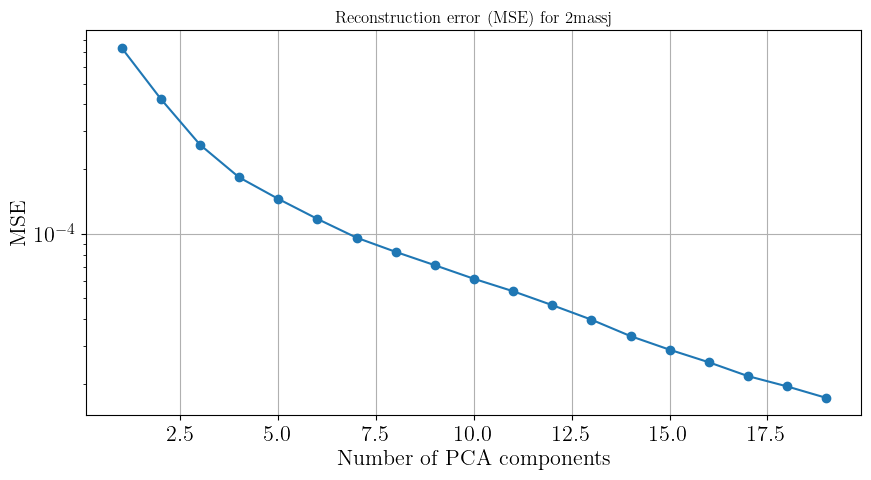

For 2massks filter, 10 components explain 0.9540554779948854 of the variance.


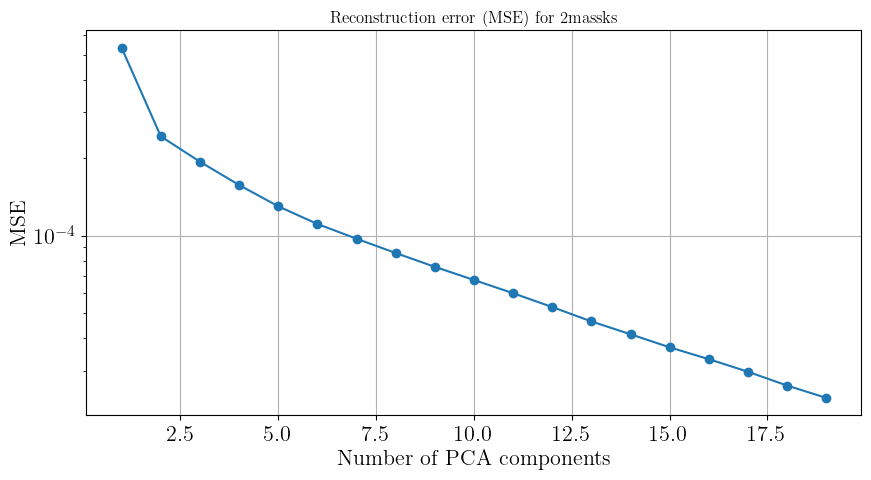

For ps1__g filter, 8 components explain 0.9533163149632082 of the variance.


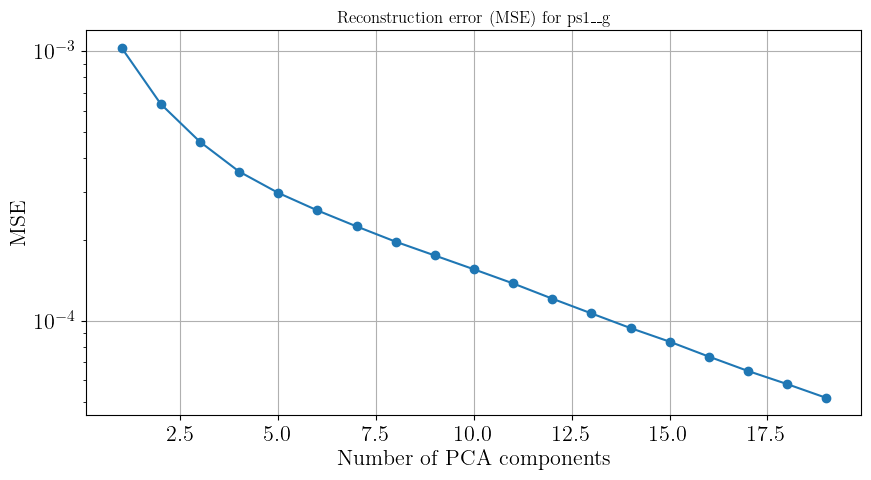

For ps1__i filter, 6 components explain 0.9629769733050217 of the variance.


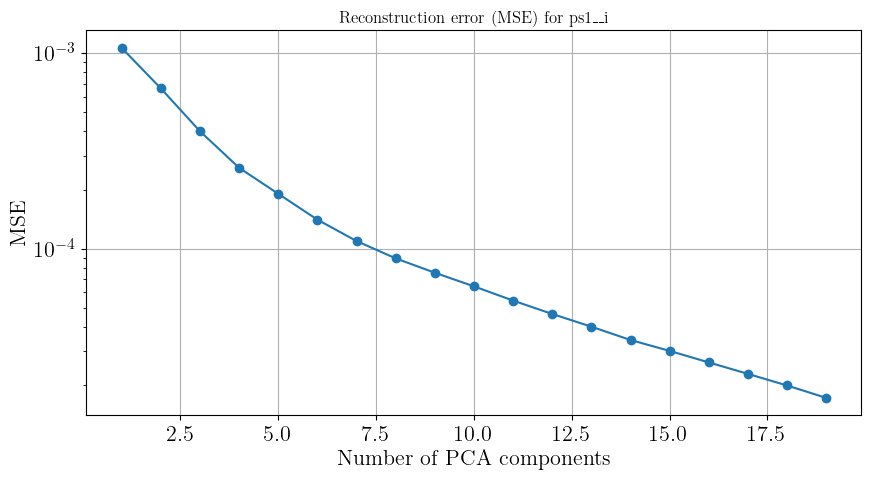

For ps1__r filter, 7 components explain 0.9548426564956967 of the variance.


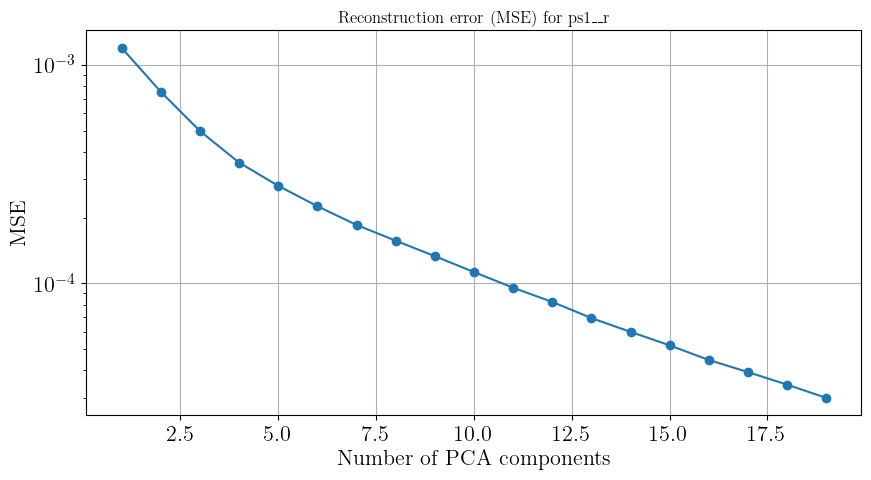

For ps1__y filter, 6 components explain 0.9526708877517343 of the variance.


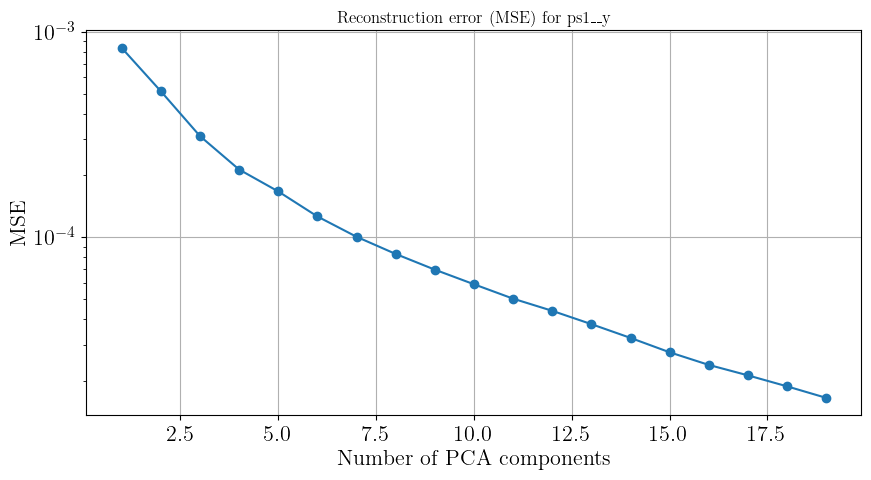

For ps1__z filter, 6 components explain 0.9595836208538236 of the variance.


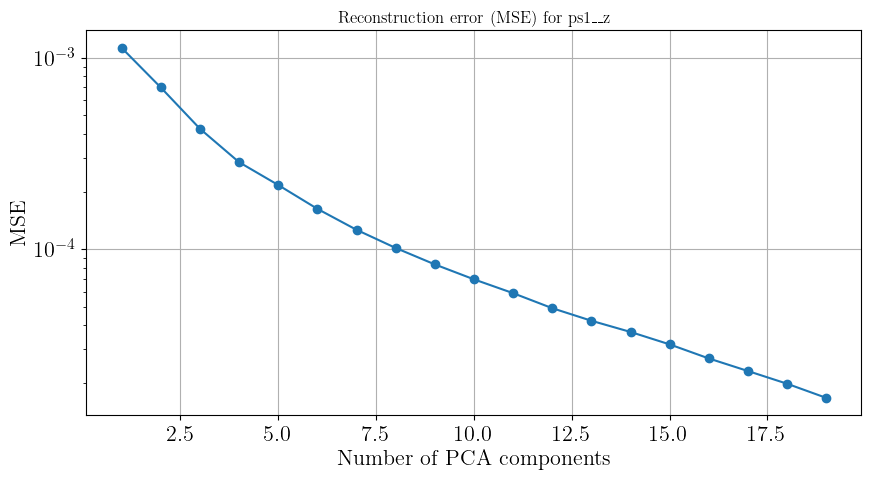

For sdssu filter, 5 components explain 0.9519887251368081 of the variance.


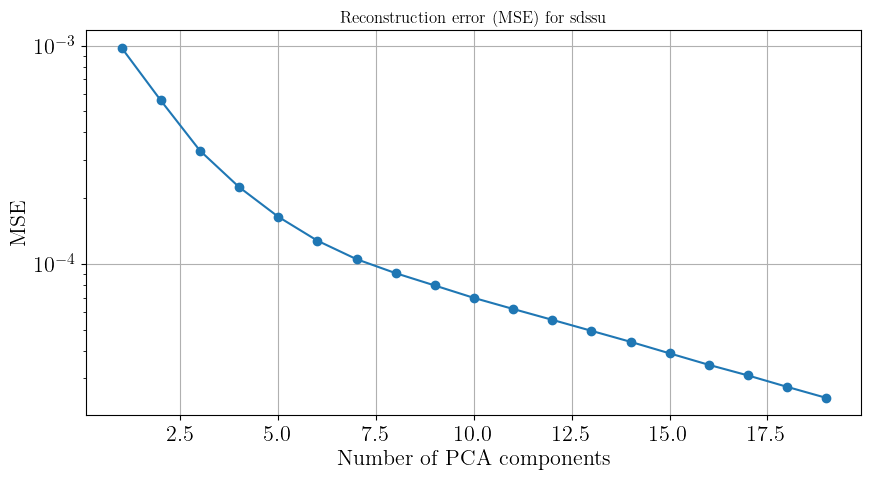

In [50]:
show_plots_explained_variance = False # whether to show plots of explained variance vs. number of PCA components or not
show_plots_reconstruction = True # whether to show plots of reconstruction error

for filt in filts:
    # X is the dataset on which the PCA will be performed
    X = data_array_postprocess_dict[filt]
    
    ### Fit the PCA and determine the number of components needed to explain certain fraction of the variance
    n_components = 0.95
    pca = PCA(n_components = n_components)
    pca.fit(X)
    print(f"For {filt} filter, {pca.n_components_} components explain {pca.explained_variance_ratio_.sum()} of the variance.")
    ratio = 1 - pca.explained_variance_ratio_
    
    if show_plots_explained_variance:
        plt.figure(figsize = (10, 5))
        plt.plot(ratio[0:], '-o')
        plt.title(f"Explained variance for {filt}")
        plt.xlabel("Number of PCA components")
        plt.ylabel("Explained variance ratio")
        plt.show()
        plt.close()
        
    ### Check the reconstruction error
    n_components_max = 20
    reconstruction_error = []
    for i in range(1, n_components_max):
        pca = PCA(n_components = i)
        pca.fit(X)
        X_reconstructed = pca.inverse_transform(pca.transform(X))
        reconstruction_error.append(mean_squared_error(X, X_reconstructed))
    
    if show_plots_reconstruction:
        plt.figure(figsize = (10, 5))
        plt.plot([i+1 for i in range(len(reconstruction_error))],reconstruction_error, '-o')
        plt.title(f"Reconstruction error (MSE) for {filt}")
        plt.xlabel("Number of PCA components")
        plt.ylabel("MSE")
        plt.yscale('log')
        plt.show()
        plt.close()

Discussion: Overall, this seems quite good. I do not see immediately any advantage to increasing beyond 10. If everything else fails, we can try bumping up to 20 components, then we achieve 99% of explained variance it seems.

### Training attempt

Note: this cell will take a very long time!

Observations: for this architecture, there is not much progress between 50 and 100 epochs, so I am keeping it at 50 for now to train an initial model, after which I can check again whether I should change/tune the architecture. But that allows me to quickly to make tests against Bu2022Ye for the fixed Ye values.

Training for 2massh filter... (1/9)
Epoch 1/50
792/792 [==============================] - 6s 6ms/step - loss: 0.0258 - val_loss: 0.0070
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 10/50
792/792 [==============================] - 5s 6ms/st

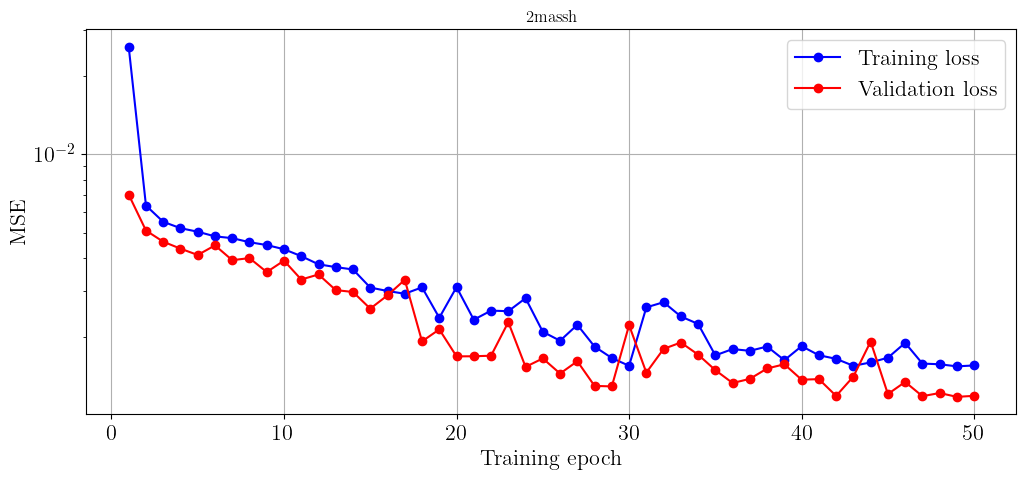

Training for 2massj filter... (2/9)
Epoch 1/50
792/792 [==============================] - 6s 6ms/step - loss: 0.0237 - val_loss: 0.0076
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 10/50
792/792 [==============================] - 5s 6ms/st

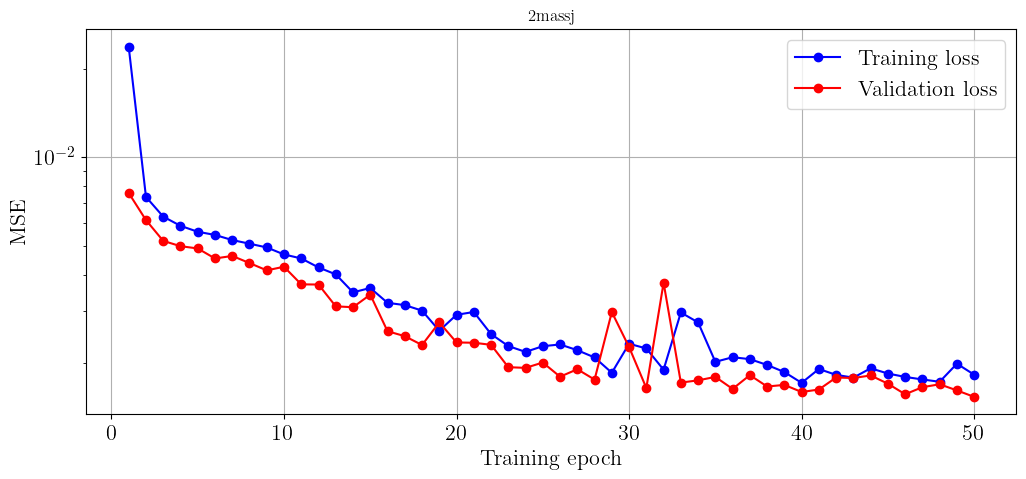

Training for 2massks filter... (3/9)
Epoch 1/50
792/792 [==============================] - 6s 6ms/step - loss: 0.0151 - val_loss: 0.0056
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/50
792/792 [==============================] - 5s 6ms/s

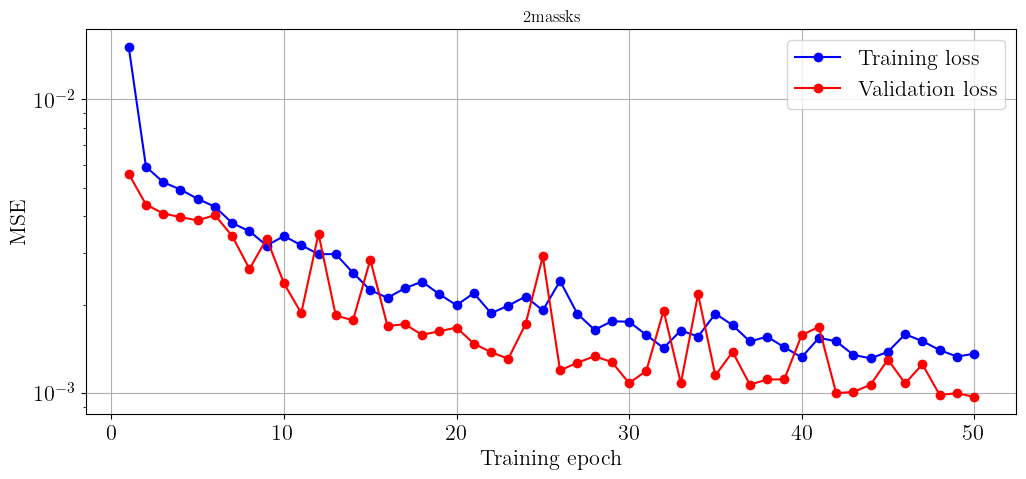

Training for ps1__g filter... (4/9)
Epoch 1/50
792/792 [==============================] - 6s 7ms/step - loss: 0.0246 - val_loss: 0.0106
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0101 - val_loss: 0.0083
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 10/50
792/792 [==============================] - 5s 6ms/st

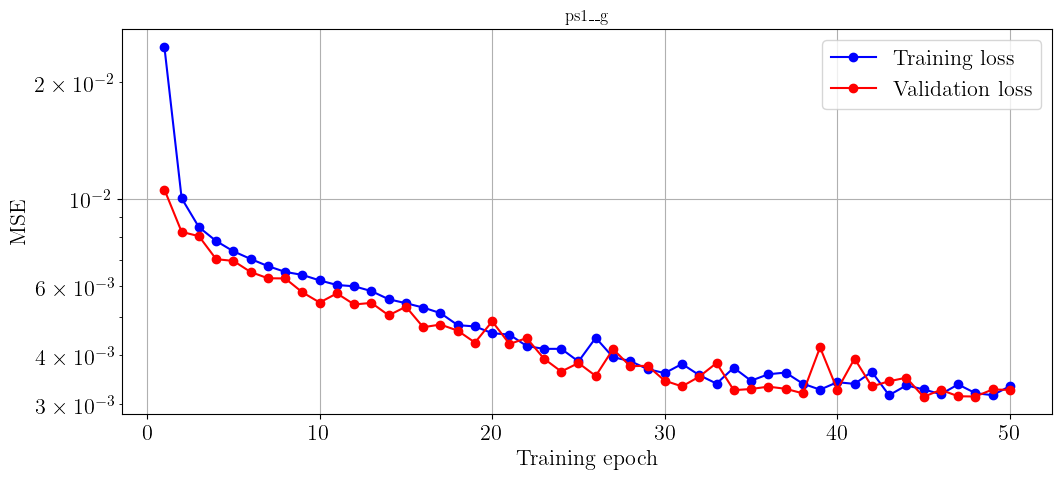

Training for ps1__i filter... (5/9)
Epoch 1/50
792/792 [==============================] - 6s 6ms/step - loss: 0.0182 - val_loss: 0.0088
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 10/50
792/792 [==============================] - 5s 6ms/st

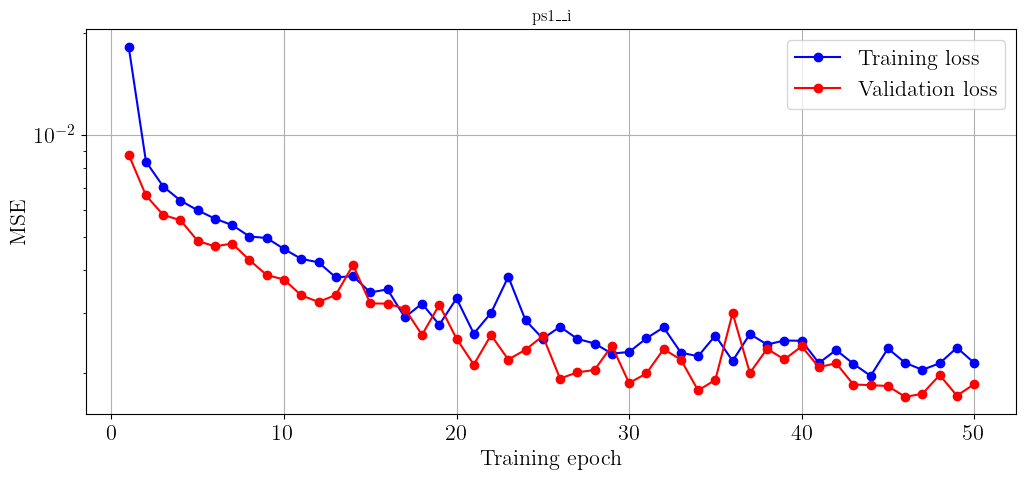

Training for ps1__r filter... (6/9)
Epoch 1/50
792/792 [==============================] - 6s 6ms/step - loss: 0.0254 - val_loss: 0.0109
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0097 - val_loss: 0.0079
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 10/50
792/792 [==============================] - 5s 6ms/st

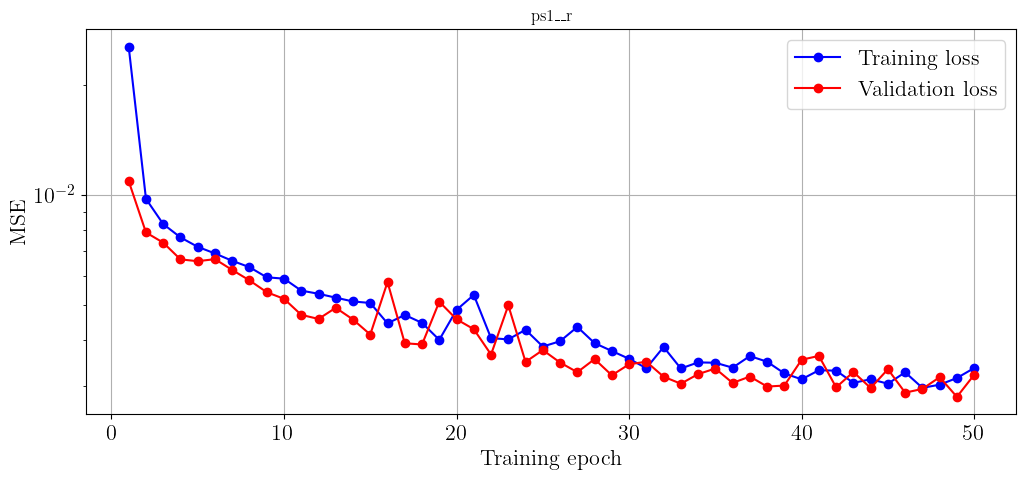

Training for ps1__y filter... (7/9)
Epoch 1/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0226 - val_loss: 0.0076
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 10/50
792/792 [==============================] - 5s 6ms/st

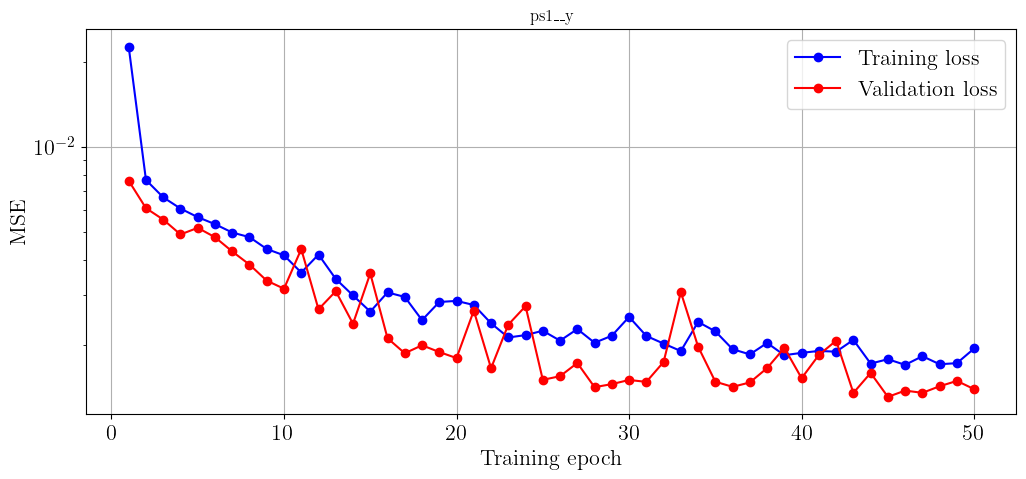

Training for ps1__z filter... (8/9)
Epoch 1/50
792/792 [==============================] - 6s 6ms/step - loss: 0.0256 - val_loss: 0.0096
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0077 - val_loss: 0.0067
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 10/50
792/792 [==============================] - 5s 6ms/st

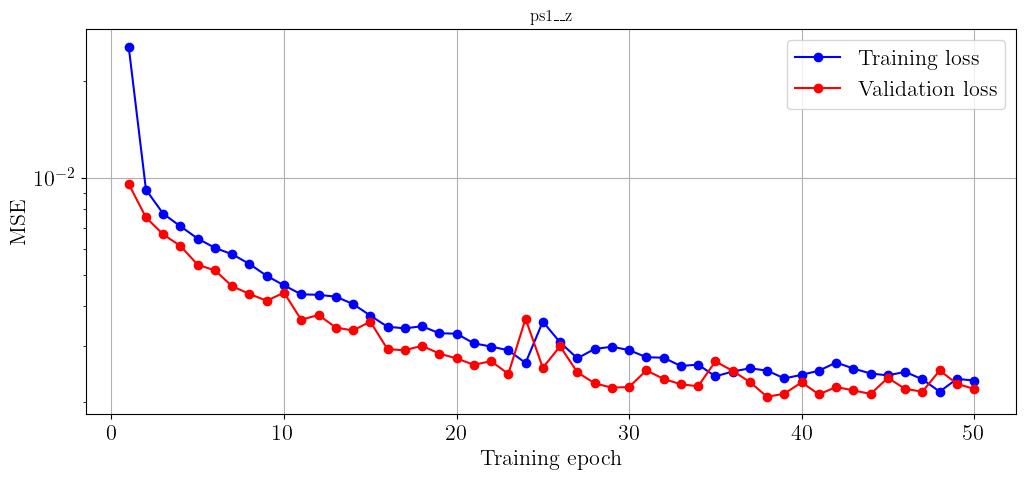

Training for sdssu filter... (9/9)
Epoch 1/50
792/792 [==============================] - 6s 6ms/step - loss: 0.0177 - val_loss: 0.0066
Epoch 2/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 3/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 4/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 5/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 6/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 7/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 8/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 9/50
792/792 [==============================] - 5s 6ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 10/50
792/792 [==============================] - 5s 6ms/ste

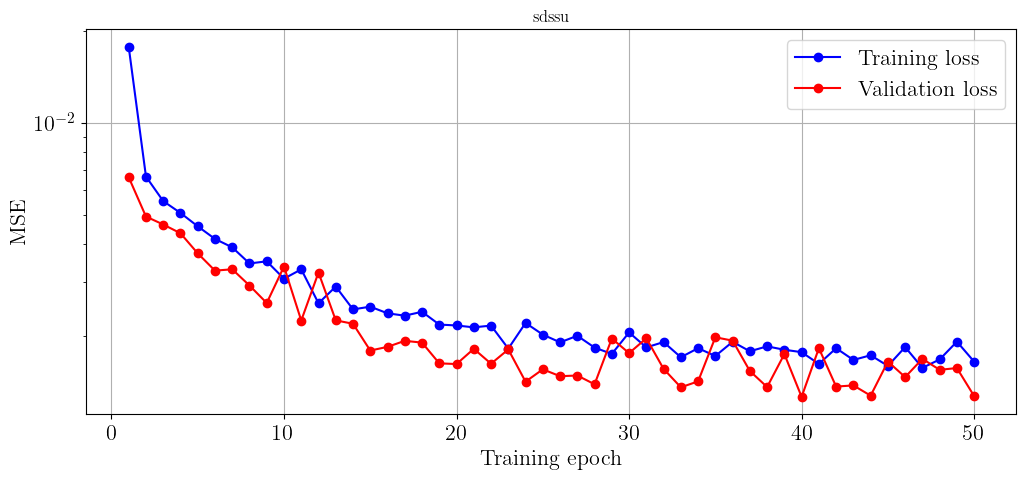

In [54]:
show_loss_curves = True

for i, filt in enumerate(filts):
    
    print(f"Training for {filt} filter... ({i+1}/{len(filts)})")

    X = training_model.svd_model[filt]['param_array_postprocess']
    n_samples, input_ndim = X.shape

    y = training_model.svd_model[filt]['cAmat'].T
    _, output_ndim = y.shape

    # Do the train validation split
    train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=0)
    
    # Build up the NN architecture
    # TODO this is chosen randomly, can improve the architecture?
    model = Sequential()
    model.add(
        Dense(
            64,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(
        Dense(
            128,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(
        Dense(
            64,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(Dense(training_model.n_coeff))

    # # Show the architecture:
    # model.summary()

    # Compile the model and fit it
    model.compile(optimizer="adam", loss="mse")
    n_epochs = 50
    training_history = model.fit(
        train_X,
        train_y,
        epochs=n_epochs,
        batch_size=32,
        validation_data=(val_X, val_y),
        verbose=True,
    )

    if show_loss_curves:
        train_loss = training_history.history["loss"]
        val_loss = training_history.history["val_loss"]
        plt.figure(figsize=(12, 5))
        plt.plot([i+1 for i in range(len(train_loss))], train_loss, '-o', color="blue", label="Training loss")
        plt.plot([i+1 for i in range(len(val_loss))], val_loss, '-o', color="red", label="Validation loss")
        plt.legend()
        plt.xlabel("Training epoch")
        plt.ylabel("MSE")
        plt.yscale('log')
        plt.title(filt)
        plt.show()
        plt.close()
        
    # Also save the model as attribute to the object, see NMMA source code for this
    training_model.svd_model[filt]["model"] = model
    

Save the models

In [55]:
svd_path = "/home/urash/twouters/new_nmma_models/Bu2023Ye_tf" # location on the Potsdam cluster
training_model.svd_path = svd_path

In [56]:
training_model.save_model()

In [57]:
print(filts) # to check if all saved correctly

['2massh', '2massj', '2massks', 'ps1__g', 'ps1__i', 'ps1__r', 'ps1__y', 'ps1__z', 'sdssu']


## Benchmarking

Our idea was to benchmark this new model for a fixed Yewind value of 0.3, since that allows us to compare its performance against

In [59]:
print(t) # times
print(t[1] - t[0]) # time step

[ 0.103  0.109  0.116  0.122  0.13   0.137  0.145  0.154  0.163  0.173
  0.183  0.194  0.206  0.218  0.231  0.244  0.259  0.274  0.29   0.308
  0.326  0.345  0.366  0.387  0.41   0.435  0.461  0.488  0.517  0.547
  0.58   0.614  0.651  0.689  0.73   0.773  0.819  0.868  0.919  0.974
  1.032  1.093  1.158  1.226  1.299  1.376  1.458  1.544  1.636  1.733
  1.836  1.944  2.06   2.182  2.311  2.448  2.594  2.747  2.91   3.083
  3.266  3.459  3.665  3.882  4.112  4.356  4.614  4.888  5.178  5.485
  5.81   6.155  6.52   6.906  7.316  7.75   8.21   8.696  9.212  9.759
 10.337 10.95  11.6   12.288 13.016 13.788 14.606 15.472 16.39  17.362
 18.392 19.482 20.638 21.862 23.158 24.532 25.987 27.528 29.16  30.89 ]
0.006000000000000005
